In [6]:
import json
import time
import numpy as np
import cupy as cp
from cupyx.profiler import benchmark

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

import quflow as qf

In [3]:
qf.gpu.gpu_core.print_info()

CuPy version: 12.0.0
Device 0: b'NVIDIA GeForce GTX 1070':
	multiprocessor count: 15


Shown below is the execution time for different matrix size $N$ for both GPU and CPU, aswell as the respective speedup. The variables `time = 3.0`, `inner_time = 0.5` and
`qstepsize = 0.2` are fixed.

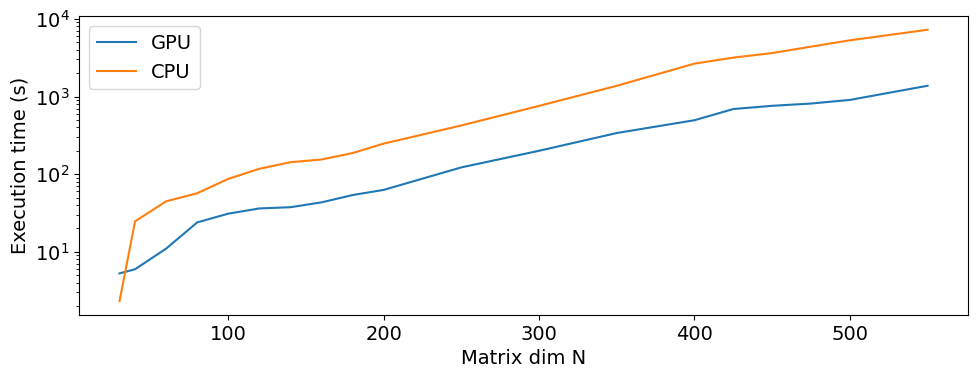

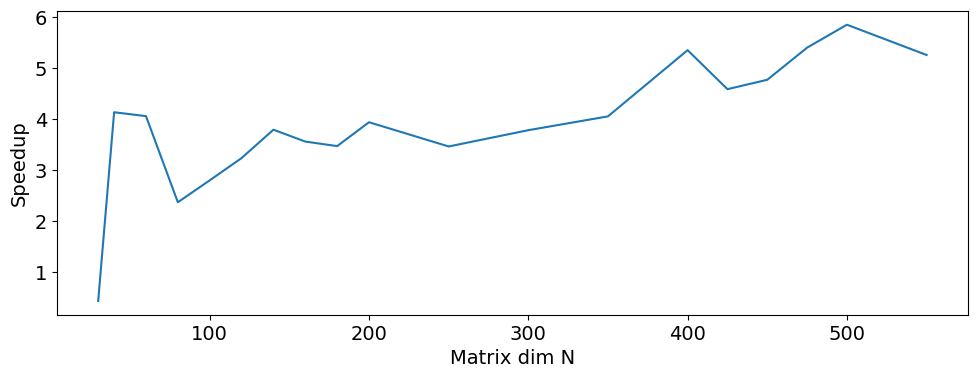

In [9]:
with open("results/speed_test2.json","r") as f:
    speed_data = json.load(f)


timings = np.array(speed_data["timings"])
n_samples = np.array(speed_data["n_samples"])

speedup = timings[1,:]/timings[0,:]

fig1, ax1 = plt.subplots(1,1,figsize = (10,4))
fig2, ax2 = plt.subplots(1,1,figsize = (10,4))


# Execution time plot
ax1.plot(n_samples,timings.T,label=["GPU","CPU"])

ax1.set_yscale("log")
#ax[0].set_xscale("log")
#ax1.set_title('Fixed time, inner_time and qstepsize')
ax1.set_ylabel("Execution time (s)")
ax1.set_xlabel("Matrix dim N")
ax1.legend()

# Speedup plot

ax2.plot(n_samples,speedup)

ax2.set_ylabel("Speedup")
ax2.set_xlabel("Matrix dim N")
#ax[1].legend()

fig1.tight_layout()
fig2.tight_layout()

fig1.savefig("results/gpu_cpu_timings.pdf")
fig2.savefig("results/gpu_cpu_speedup.pdf")

In [11]:
def get_random_mat_cp(N=5,seed=None):
    if seed != None:
        cp.random.seed(seed)

    W = cp.random.randn(N, N) + 1j*cp.random.randn(N, N)
    W -= W.conj().T
    W -= cp.eye(N)*cp.trace(W)/N
    return W

def get_random_mat_np(N=5,seed=None):
    if seed != None:
        np.random.seed(seed)

    W = np.random.randn(N, N) + 1j*np.random.randn(N, N)
    W -= W.conj().T
    W -= np.eye(N)*np.trace(W)/N
    return W

def mult(A,B,C):
    cp.matmul(A,B,out=C)

N=1048
N=2048
N=4096


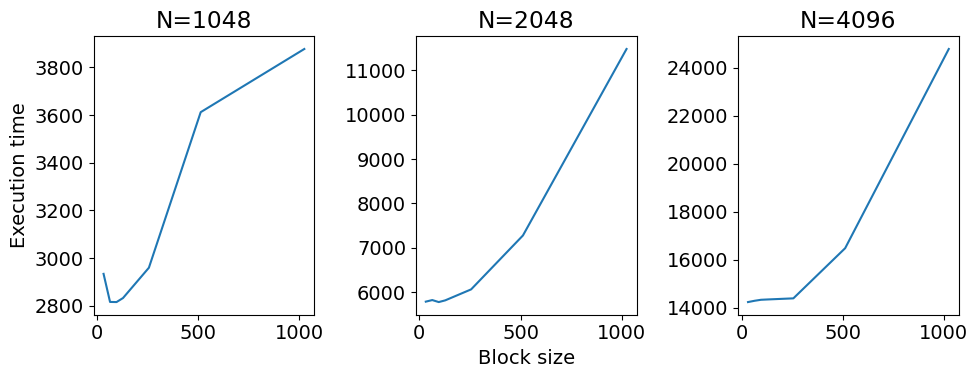

In [20]:
# ------- Testing block size for skew-herm cuThomas --------- #



N_list = np.array([1048,2048,4096]) # Size of matrices <---- Needs 
fig1,ax1 = plt.subplots(1,len(N_list),figsize=(10,4))

block_size_samples = np.array([32,64,96,128,256,512,1024])
block_size_timings = np.zeros((len(N_list),len(block_size_samples)))
#N = 2048 # Size of matrix
n_repeat = 1000
n_repeat_cpu = 10

# Cupy arrays
for (i,N) in enumerate(N_list):
    print(f"N={N}")
    W0_cp = get_random_mat_cp(N)

    P0_cp = cp.zeros_like(W0_cp)
    ham_cp = qf.gpu.gpu_core.solve_poisson_interleaved_cp(N)

    for (j,b_size) in enumerate(block_size_samples):
        block_size_timings[i,j] = benchmark(ham_cp.solve_poisson,(W0_cp,P0_cp,b_size),n_repeat=n_repeat).gpu_times[0].mean()*1e6
    
    ax1[i].plot(block_size_samples,block_size_timings[i])
    if i == 0:
        ax1[i].set_ylabel("Execution time")
    if i == 1:
        ax1[i].set_xlabel("Block size")
    ax1[i].set_title(f"N={N}")
    #ax1[i].legend()

    del W0_cp
    del P0_cp
    del ham_cp


fig1.tight_layout()

fig1.savefig("results/block_size_timing.pdf")


In [21]:
for i in range(3):
    ax1[i].set_xscale("log")
fig1.savefig("results/block_size_timing.pdf")

[[3.74080000e+02 1.16720000e+02 3.27800000e+02 3.77735000e+03
  5.61593000e+03 7.98254000e+03 1.42904300e+04 1.89825700e+04
  2.34835100e+04 3.40283600e+04 5.34438100e+04 8.00055700e+04
  1.26947230e+05 1.53786660e+05 2.62797610e+05 2.88246510e+05]
 [9.94324481e+02 1.23195424e+03 1.96529600e+03 2.86788286e+03
  2.71884801e+03 3.34835198e+03 4.46279998e+03 5.03913274e+03
  4.51016641e+03 4.78871675e+03 5.91114554e+03 7.20952959e+03
  8.91511669e+03 1.21696511e+04 1.27071103e+04 1.43285887e+04]
 [1.66585375e+03 1.51365472e+03 2.26809857e+03 2.67790977e+03
  3.28427198e+03 4.52737918e+03 5.61948161e+03 8.69222722e+03
  9.31024952e+03 7.52592316e+03 1.05664865e+04 1.74222754e+04
  2.19273472e+04 2.64699455e+04 2.64187456e+04 3.18923906e+04]]


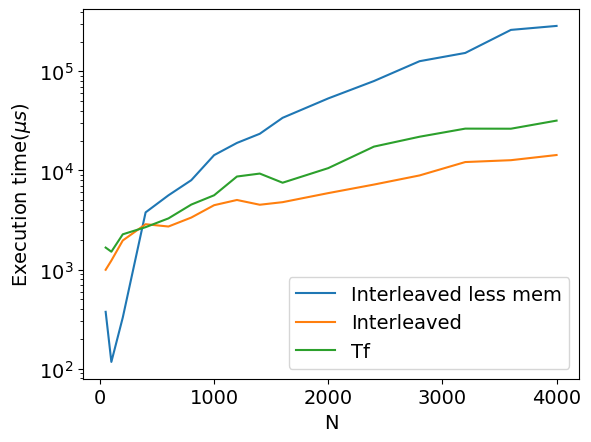

In [25]:
# ----------- comparing the different tridiagonal solvers ------- #

#N_samples = np.array([50,100,200,400,600,800,1000,1200,1400,1600,2000,2400,2800,3200,3600,4000]) # Size of matrices
N_samples = np.array([50,100,200,400,600,800,1000,1200,1400,1600,2000,2400,2800,3200,3600,4000])
#N = 2048 # Size of matrix
n_repeat = 1000
n_repeat_cpu = 10

timings = np.zeros((3,len(N_samples)))

# Cupy arrays

for (i,N) in enumerate(N_samples):
    W0_cp = get_random_mat_cp(N)
    

    W0 = W0_cp.get()

    cpu_timing_total = 0
    if N < 500:
        n_repeat = 100
    else:
        n_repeat = 10
    for _ in range(n_repeat_cpu):
        qf.compute_direct_laplacian(N, bc=True)
        cpu_timing_start = time.time_ns()
        P0 = qf.solve_poisson(W0)
        cpu_timing_total += (time.time_ns()-cpu_timing_start)/1e3
    timings[0,i] = cpu_timing_total / n_repeat_cpu
    del W0
    del P0


    P0_c = cp.zeros_like(W0_cp)
    ham_c = qf.gpu.gpu_core.solve_poisson_interleaved_cp(N)
    timings[1,i] = benchmark(ham_c.solve_poisson,(W0_cp,P0_c),n_repeat=n_repeat).gpu_times[0].mean()*1e6
    del ham_c
    del P0_c

    P0_tf = cp.zeros_like(W0_cp)
    ham_tf = qf.gpu.gpu_tf.solve_poisson_cp(N)
    timings[2,i] = benchmark(ham_tf.solve_poisson,(W0_cp,P0_tf),n_repeat=n_repeat).gpu_times[0].mean()*1e6
    del ham_tf
    del P0_tf

    del W0_cp

print(timings)

speedup = np.array(timings[1:,i]/timings[0,i] for i in range(timings.shape[1])

fig,ax = plt.subplots()
plt.figure()
plt.plot(N_samples,timings[0], label ="Interleaved less mem" )
plt.plot(N_samples,timings[1], label ="Interleaved" )
plt.plot(N_samples,timings[2], label ="Tensorflow" )

plt.ylabel("Execution time($\mu s$)")
plt.xlabel("N")
plt.yscale("log")
plt.legend()
plt.show()


[[  2539.125         835.831        9311.649       20449.439
   44682.661      112764.26       196191.702     ]
 [   766.32255033    569.73087892    907.91040659   3657.95936823
   10985.65279961  23243.33089828  43341.94274902]]


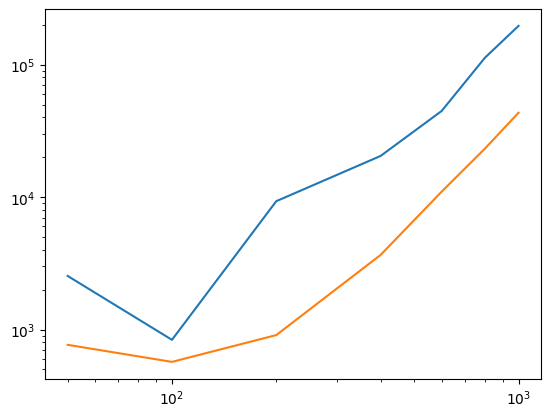

In [10]:
# ----------- matmul speed test ------- #

N_samples = np.array([50,100,200,400,600,800,1000,1200,1400,1600])
n_repeat = 100
n_repeat_cpu = 10

timings = np.zeros((2,len(N_samples)))

for (i,N) in enumerate(N_samples):
    A_cp = get_random_mat_cp(N,1)
    B_cp = get_random_mat_cp(N,2)
    C_cp = cp.empty_like(A_cp)

    A = A_cp.get()
    B = B_cp.get()
    C = np.zeros_like(B)
    cpu_timing_total = 0
    for _ in range(n_repeat_cpu):
        cpu_timing_start = time.time_ns()
        np.matmul(A, B, out=C)
        cpu_timing_total += (time.time_ns()-cpu_timing_start)
    timings[0,i] = cpu_timing_total / (n_repeat_cpu*1e3)


    timings[1,i] = benchmark(mult,(A_cp,B_cp,C_cp),n_repeat=n_repeat).gpu_times[0].mean()*1e6
    
    del A
    del B
    del C

    del A_cp
    del B_cp
    del C_cp

print(timings)

plt.figure()
plt.plot(N_samples,timings[0])
plt.plot(N_samples,timings[1])
plt.yscale("log")
plt.xscale("log")
plt.show()

